In [1]:
import pandas as pd

import torch
import wandb

In [2]:
torch.cuda.is_available(), torch.cuda.is_bf16_supported()
value_considered_as_fewshot=3

## Summarize results from CIFAR-100

* There are 10 tasks
* Each task has to learn 10 classes
* Classes from one task do not appear in other tasks
* The model knows from which taks a sample belongs (This scenario is knwons as Task Incremental Learning)

In [3]:
val_acc_by_experiment_cifar100 = {'lora': [], 'sena': []}
last_run_cifar100 = {'lora': None, 'sena': None}

api = wandb.Api()
runs = api.runs("cf-lora-cifar100")

for run in runs:
    run_name = run.name
    best_values = []
    init_values = []
    num_epochs = []
    
    best_val=-1.
    init_val=-1.
    number_of_epochs=0
    
    hist = run.history()
    best_val_acc=hist['best_val_acc'].values
    for v in best_val_acc:
        if v < best_val:
            best_values.append(best_val)
            init_values.append(init_val)
            num_epochs.append(number_of_epochs)
            
            best_val=-1.
            init_val=-1
            number_of_epochs=0
        else:
            best_val = v
        
        number_of_epochs += 1
        if number_of_epochs <= value_considered_as_fewshot and v > init_val:
            init_val = v

    best_values.append(best_val_acc[-1])
    init_values.append(init_val)
    num_epochs.append(number_of_epochs)
    
    key_exp = 'lora' if '-lora-' in run_name else 'sena'
    if key_exp == 'lora': # Has to continue and not process, because the the results of lora will be taken from runs in 'cf-lora-cifar-100-loravgg19'
        continue
    print(run_name)
    if '-9' in run_name:
        last_run_cifar100[key_exp] = run
        
    val_acc_by_experiment_cifar100[key_exp].append({
        "best_values": best_values,
        "init_values": init_values,
        "num_epochs": num_epochs,
    })


runs = api.runs("cf-lora-cifar-100-loravgg19")

for run in runs:
    run_name = run.name
    
    best_values = []
    init_values = []
    num_epochs = []
    
    best_val=-1.
    init_val=-1.
    number_of_epochs=0
    
    hist = run.history()
    best_val_acc=hist['best_val_acc'].values
    for v in best_val_acc:
        if v < best_val:
            best_values.append(best_val)
            init_values.append(init_val)
            num_epochs.append(number_of_epochs)
            
            best_val=-1.
            init_val=-1
            number_of_epochs=0
        else:
            best_val = v

        number_of_epochs += 1
        if number_of_epochs <= value_considered_as_fewshot and v > init_val:
            init_val = v

    best_values.append(best_val_acc[-1])
    init_values.append(init_val)
    num_epochs.append(number_of_epochs)
    
    key_exp = 'lora'
    print(run_name)
    if '-9' in run_name:
        last_run_cifar100[key_exp] = run
        
    val_acc_by_experiment_cifar100[key_exp].append({
        "best_values": best_values,
        "init_values": init_values,
        "num_epochs": num_epochs,
    })

vgg19-lr-00001-10tasks-sena-0
vgg19-lr-00001-10tasks-sena-1
vgg19-lr-00001-10tasks-sena-2
vgg19-lr-00001-10tasks-sena-3
vgg19-lr-00001-10tasks-sena-4
vgg19-lr-00001-10tasks-sena-5
vgg19-lr-00001-10tasks-sena-6
vgg19-lr-00001-10tasks-sena-7
vgg19-lr-00001-10tasks-sena-8
vgg19-lr-00001-10tasks-sena-9
lora-vgg19-lr-1e-05-10tasks-lora-1
lora-vgg19-lr-1e-05-10tasks-lora-6
lora-vgg19-lr-1e-05-10tasks-lora-2
lora-vgg19-lr-1e-05-10tasks-lora-3
lora-vgg19-lr-1e-05-10tasks-lora-4
lora-vgg19-lr-1e-05-10tasks-lora-5
lora-vgg19-lr-1e-05-10tasks-lora-7
lora-vgg19-lr-1e-05-10tasks-lora-8
lora-vgg19-lr-1e-05-10tasks-lora-9
lora-vgg19-lr-1e-05-10tasks-lora-10


In [4]:
best_values,init_values,num_epochs

([0.829, 0.873, 0.847, 0.877, 0.861, 0.864, 0.802, 0.851, 0.865, 0.819],
 [0.366, 0.494, 0.487, 0.528, 0.424, 0.468, 0.434, 0.419, 0.52, 0.474],
 [69, 35, 54, 41, 61, 43, 28, 62, 47, 32])

In [5]:
lora_best_val_cifar100 = pd.DataFrame([exp['best_values'] for exp in val_acc_by_experiment_cifar100['lora']])
for col in lora_best_val_cifar100.columns:
    max_idx = lora_best_val_cifar100[col].idxmax()
    min_idx = lora_best_val_cifar100[col].idxmin()
    lora_best_val_cifar100.at[max_idx, col] = 0
    lora_best_val_cifar100.at[min_idx, col] = 0
    
lora_best_val_cifar100 = lora_best_val_cifar100.apply(lambda x: x.sort_values().values)
lora_best_val_cifar100 = lora_best_val_cifar100.iloc[2:]
# lora_best_val_cifar100 = lora_best_val_cifar100.T.values

lora_init_val_cifar100 = pd.DataFrame([exp['init_values'] for exp in val_acc_by_experiment_cifar100['lora']])
for col in lora_init_val_cifar100.columns:
    max_idx = lora_init_val_cifar100[col].idxmax()
    min_idx = lora_init_val_cifar100[col].idxmin()
    lora_init_val_cifar100.at[max_idx, col] = 0
    lora_init_val_cifar100.at[min_idx, col] = 0
    
lora_init_val_cifar100 = lora_init_val_cifar100.apply(lambda x: x.sort_values().values)
lora_init_val_cifar100 = lora_init_val_cifar100.iloc[2:]
# lora_init_val_cifar100 = lora_init_val_cifar100.T.values

lora_epochs_cifar100 = pd.DataFrame([exp['num_epochs'] for exp in val_acc_by_experiment_cifar100['lora']])
for col in lora_epochs_cifar100.columns:
    max_idx = lora_epochs_cifar100[col].idxmax()
    min_idx = lora_epochs_cifar100[col].idxmin()
    lora_epochs_cifar100.at[max_idx, col] = 0
    lora_epochs_cifar100.at[min_idx, col] = 0
    
lora_epochs_cifar100 = lora_epochs_cifar100.apply(lambda x: x.sort_values().values)
lora_epochs_cifar100 = lora_epochs_cifar100.iloc[2:]
# lora_epochs_cifar100 = lora_epochs_cifar100.T.values



sena_best_val_cifar100 = pd.DataFrame([exp['best_values'] for exp in val_acc_by_experiment_cifar100['sena']])
for col in sena_best_val_cifar100.columns:
    max_idx = sena_best_val_cifar100[col].idxmax()
    min_idx = sena_best_val_cifar100[col].idxmin()
    sena_best_val_cifar100.at[max_idx, col] = 0
    sena_best_val_cifar100.at[min_idx, col] = 0
    
sena_best_val_cifar100 = sena_best_val_cifar100.apply(lambda x: x.sort_values().values)
sena_best_val_cifar100 = sena_best_val_cifar100.iloc[2:]
# sena_best_val_cifar100 = sena_best_val_cifar100.T.values

sena_init_val_cifar100 = pd.DataFrame([exp['init_values'] for exp in val_acc_by_experiment_cifar100['sena']])
for col in sena_init_val_cifar100.columns:
    max_idx = sena_init_val_cifar100[col].idxmax()
    min_idx = sena_init_val_cifar100[col].idxmin()
    sena_init_val_cifar100.at[max_idx, col] = 0
    sena_init_val_cifar100.at[min_idx, col] = 0
    
sena_init_val_cifar100 = sena_init_val_cifar100.apply(lambda x: x.sort_values().values)
sena_init_val_cifar100 = sena_init_val_cifar100.iloc[2:]
# sena_init_val_cifar100 = sena_init_val_cifar100.T.values

sena_epochs_cifar100 = pd.DataFrame([exp['num_epochs'] for exp in val_acc_by_experiment_cifar100['sena']])
for col in sena_epochs_cifar100.columns:
    max_idx = sena_epochs_cifar100[col].idxmax()
    min_idx = sena_epochs_cifar100[col].idxmin()
    sena_epochs_cifar100.at[max_idx, col] = 0
    sena_epochs_cifar100.at[min_idx, col] = 0
    
sena_epochs_cifar100 = sena_epochs_cifar100.apply(lambda x: x.sort_values().values)
sena_epochs_cifar100 = sena_epochs_cifar100.iloc[2:]
# sena_epochs_cifar100 = sena_epochs_cifar100.T.values

In [7]:
lora_best_val_cifar100

,0,1,2,3,4,5,6,7,8,9
2,0.819,0.866,0.833,0.878,0.848,0.859,0.802,0.836,0.845,0.820
3,0.819,0.870,0.838,0.884,0.849,0.860,0.802,0.838,0.847,0.835
4,0.822,0.872,0.839,0.886,0.851,0.860,0.809,0.839,0.850,0.844
5,0.829,0.873,0.839,0.886,0.853,0.864,0.818,0.839,0.860,0.848
6,0.830,0.878,0.843,0.887,0.854,0.864,0.820,0.841,0.861,0.850
7,0.835,0.881,0.843,0.892,0.857,0.865,0.824,0.841,0.865,0.852
8,0.835,0.886,0.845,0.893,0.859,0.871,0.824,0.844,0.865,0.854
9,0.835,0.887,0.847,0.893,0.861,0.873,0.832,0.851,0.865,0.856


In [8]:
sena_best_val_cifar100

,0,1,2,3,4,5,6,7,8,9
2,0.823,0.882,0.835,0.881,0.843,0.854,0.826,0.853,0.852,0.834
3,0.842,0.884,0.836,0.883,0.848,0.860,0.830,0.856,0.855,0.838
4,0.851,0.885,0.839,0.884,0.851,0.863,0.835,0.857,0.860,0.854
5,0.852,0.886,0.841,0.888,0.857,0.866,0.835,0.858,0.861,0.857
6,0.853,0.887,0.848,0.889,0.860,0.867,0.836,0.860,0.865,0.858
7,0.858,0.896,0.850,0.891,0.865,0.868,0.838,0.861,0.868,0.860
8,0.860,0.896,0.852,0.891,0.867,0.868,0.839,0.862,0.868,0.864
9,0.860,0.899,0.855,0.898,0.867,0.872,0.839,0.867,0.871,0.867


In [16]:
mean_std_df_cifar100 = pd.DataFrame({
    # 'Sena Initial Accuracy Mean': sena_init_val_cifar100.mean(),
    # 'Sena Initial Accuracy Std': sena_init_val_cifar100.std(),
    'Sena Final Accuracy Mean': sena_best_val_cifar100.mean(),
    'Sena Final Accuracy Std': sena_best_val_cifar100.std(),
    'Sena Epochs Mean': sena_epochs_cifar100.mean(),
    'Sena Epochs Std': sena_epochs_cifar100.std(),
    
    # 'Lora Initial Accuracy Mean': lora_init_val_cifar100.mean(),
    # 'Lora Initial Accuracy Std': lora_init_val_cifar100.std(),
    'Lora Final Accuracy Mean': lora_best_val_cifar100.mean(),
    'Lora Final Accuracy Std': lora_best_val_cifar100.std(),
    'Lora Epochs Mean': lora_epochs_cifar100.mean(),
    'Lora Epochs Std': lora_epochs_cifar100.std(),
})

mean_std_df_cifar100

,Sena Final Accuracy Mean,Sena Final Accuracy Std,Sena Epochs Mean,Sena Epochs Std,Lora Final Accuracy Mean,Lora Final Accuracy Std,Lora Epochs Mean,Lora Epochs Std
0,0.849875,0.012369,45.125,11.933596,0.828000,0.007071,67.000,7.329003
1,0.889375,0.006545,31.000,4.720775,0.876625,0.007633,41.250,5.922114
2,0.844500,0.007690,32.500,6.187545,0.840875,0.004486,54.250,2.764572
3,0.888125,0.005463,31.875,6.978283,0.887375,0.005181,48.875,6.512351
4,0.857250,0.009146,37.500,5.656854,0.854000,0.004690,53.250,4.590363
5,0.864750,0.005625,29.750,5.063878,0.864500,0.005155,43.250,6.065123
6,0.834750,0.004590,31.125,3.482097,0.816375,0.010980,37.875,6.289163
7,0.859250,0.004268,36.625,2.774244,0.841125,0.004643,50.750,6.341473
8,0.862500,0.006698,32.500,5.451081,0.857250,0.008531,40.500,3.251373
9,0.854000,0.011868,37.750,7.535630,0.844875,0.012017,48.750,9.676924


## Summarize results from CUBs-200

* There are 5 tasks
* First task has 100 classes, and each other has to learn 25 classes
* Classes from one task do not appear in other tasks
* The model knows from which taks a sample belongs (This scenario is knwons as Task Incremental Learning)

In [10]:
val_acc_by_experiment_cubs200 = {'lora': [], 'sena': []}
last_run_cubs200 = {'lora': None, 'sena': None}

api = wandb.Api()
runs = api.runs("cf-lora-cubs200")

for run in runs:
    run_name = run.name
    best_values = []
    init_values = []
    num_epochs = []
    
    best_val=-1.
    init_val=-1.
    number_of_epochs=0
    
    hist = run.history()
    best_val_acc=hist['best_val_acc'].values
    for v in best_val_acc:
        if v < best_val:
            best_values.append(best_val)
            init_values.append(init_val)
            num_epochs.append(number_of_epochs)
            
            best_val=-1.
            init_val=-1
            number_of_epochs=0
        else:
            best_val = v
        
        number_of_epochs += 1
        if number_of_epochs <= value_considered_as_fewshot and v > init_val:
            init_val = v

    best_values.append(best_val_acc[-1])
    init_values.append(init_val)
    num_epochs.append(number_of_epochs)
    
    key_exp = 'lora' if '-lora-' in run_name else 'sena'
    if key_exp == 'lora': # Has to continue and not process, because the the results of lora will be taken from runs in 'cf-lora-cifar-100-loravgg19'
        continue
    print(run_name)
    if '-9' in run_name:
        last_run_cubs200[key_exp] = run
        
    val_acc_by_experiment_cubs200[key_exp].append({
        "best_values": best_values,
        "init_values": init_values,
        "num_epochs": num_epochs,
    })


runs = api.runs("cf-lora-cub-200-loravgg19")

for run in runs:
    run_name = run.name
    
    best_values = []
    init_values = []
    num_epochs = []
    
    best_val=-1.
    init_val=-1.
    number_of_epochs=0
    
    hist = run.history()
    best_val_acc=hist['best_val_acc'].values
    for v in best_val_acc:
        if v < best_val:
            best_values.append(best_val)
            init_values.append(init_val)
            num_epochs.append(number_of_epochs)
            
            best_val=-1.
            init_val=-1
            number_of_epochs=0
        else:
            best_val = v

        number_of_epochs += 1
        if number_of_epochs <= value_considered_as_fewshot and v > init_val:
            init_val = v

    best_values.append(best_val_acc[-1])
    init_values.append(init_val)
    num_epochs.append(number_of_epochs)
    
    key_exp = 'lora'
    print(run_name)
    if '-9' in run_name:
        last_run_cubs200[key_exp] = run
        
    val_acc_by_experiment_cubs200[key_exp].append({
        "best_values": best_values,
        "init_values": init_values,
        "num_epochs": num_epochs,
    })

vgg19-lr-00001-5tasks-sena-0
vgg19-lr-00001-5tasks-sena-1
vgg19-lr-00001-5tasks-sena-3
vgg19-lr-00001-5tasks-sena-4
vgg19-lr-00001-5tasks-sena-5
vgg19-lr-00001-5tasks-sena-6
vgg19-lr-00001-5tasks-sena-7
vgg19-lr-00001-5tasks-sena-8
vgg19-lr-00001-5tasks-sena-9
vgg19-lr-00001-5tasks-sena-2
lora-vgg19-lr-1e-05-5tasks-lora-1
lora-vgg19-lr-1e-05-5tasks-lora-2
lora-vgg19-lr-1e-05-5tasks-lora-3
lora-vgg19-lr-1e-05-5tasks-lora-4
lora-vgg19-lr-1e-05-5tasks-lora-5
lora-vgg19-lr-1e-05-5tasks-lora-6
lora-vgg19-lr-1e-05-5tasks-lora-7
lora-vgg19-lr-1e-05-5tasks-lora-8
lora-vgg19-lr-1e-05-5tasks-lora-9
lora-vgg19-lr-1e-05-5tasks-lora-10


In [11]:
lora_best_val_cubs200 = pd.DataFrame([exp['best_values'] for exp in val_acc_by_experiment_cubs200['lora']])
for col in lora_best_val_cubs200.columns:
    max_idx = lora_best_val_cubs200[col].idxmax()
    min_idx = lora_best_val_cubs200[col].idxmin()
    lora_best_val_cubs200.at[max_idx, col] = 0
    lora_best_val_cubs200.at[min_idx, col] = 0
    
lora_best_val_cubs200 = lora_best_val_cubs200.apply(lambda x: x.sort_values().values)
lora_best_val_cubs200 = lora_best_val_cubs200.iloc[2:]
# lora_best_val_cubs200 = lora_best_val_cubs200.T.values

lora_init_val_cubs200 = pd.DataFrame([exp['init_values'] for exp in val_acc_by_experiment_cubs200['lora']])
for col in lora_init_val_cubs200.columns:
    max_idx = lora_init_val_cubs200[col].idxmax()
    min_idx = lora_init_val_cubs200[col].idxmin()
    lora_init_val_cubs200.at[max_idx, col] = 0
    lora_init_val_cubs200.at[min_idx, col] = 0
    
lora_init_val_cubs200 = lora_init_val_cubs200.apply(lambda x: x.sort_values().values)
lora_init_val_cubs200 = lora_init_val_cubs200.iloc[2:]
# lora_init_val_cubs200 = lora_init_val_cubs200.T.values

lora_epochs_cubs200 = pd.DataFrame([exp['num_epochs'] for exp in val_acc_by_experiment_cubs200['lora']])
for col in lora_epochs_cubs200.columns:
    max_idx = lora_epochs_cubs200[col].idxmax()
    min_idx = lora_epochs_cubs200[col].idxmin()
    lora_epochs_cubs200.at[max_idx, col] = 0
    lora_epochs_cubs200.at[min_idx, col] = 0
    
lora_epochs_cubs200 = lora_epochs_cubs200.apply(lambda x: x.sort_values().values)
lora_epochs_cubs200 = lora_epochs_cubs200.iloc[2:]
# lora_epochs_cubs200 = lora_epochs_cubs200.T.values



sena_best_val_cubs200 = pd.DataFrame([exp['best_values'] for exp in val_acc_by_experiment_cubs200['sena']])
for col in sena_best_val_cubs200.columns:
    max_idx = sena_best_val_cubs200[col].idxmax()
    min_idx = sena_best_val_cubs200[col].idxmin()
    sena_best_val_cubs200.at[max_idx, col] = 0
    sena_best_val_cubs200.at[min_idx, col] = 0
    
sena_best_val_cubs200 = sena_best_val_cubs200.apply(lambda x: x.sort_values().values)
sena_best_val_cubs200 = sena_best_val_cubs200.iloc[2:]
# sena_best_val_cubs200 = sena_best_val_cubs200.T.values

sena_init_val_cubs200 = pd.DataFrame([exp['init_values'] for exp in val_acc_by_experiment_cubs200['sena']])
for col in sena_init_val_cubs200.columns:
    max_idx = sena_init_val_cubs200[col].idxmax()
    min_idx = sena_init_val_cubs200[col].idxmin()
    sena_init_val_cubs200.at[max_idx, col] = 0
    sena_init_val_cubs200.at[min_idx, col] = 0
    
sena_init_val_cubs200 = sena_init_val_cubs200.apply(lambda x: x.sort_values().values)
sena_init_val_cubs200 = sena_init_val_cubs200.iloc[2:]
# sena_init_val_cubs200 = sena_init_val_cubs200.T.values

sena_epochs_cubs200 = pd.DataFrame([exp['num_epochs'] for exp in val_acc_by_experiment_cubs200['sena']])
for col in sena_epochs_cubs200.columns:
    max_idx = sena_epochs_cubs200[col].idxmax()
    min_idx = sena_epochs_cubs200[col].idxmin()
    sena_epochs_cubs200.at[max_idx, col] = 0
    sena_epochs_cubs200.at[min_idx, col] = 0
    
sena_epochs_cubs200 = sena_epochs_cubs200.apply(lambda x: x.sort_values().values)
sena_epochs_cubs200 = sena_epochs_cubs200.iloc[2:]
# sena_epochs_cubs200 = sena_epochs_cubs200.T.values

In [12]:
lora_best_val_cubs200

,0,1,2,3,4
2,0.696927,0.703081,0.673797,0.738776,0.818554
3,0.697975,0.704482,0.691176,0.779592,0.834925
4,0.707402,0.724090,0.695187,0.780952,0.840382
5,0.711592,0.726891,0.697861,0.790476,0.843111
6,0.714385,0.731092,0.697861,0.806803,0.845839
7,0.723115,0.733894,0.699198,0.808163,0.845839
8,0.739874,0.735294,0.703209,0.812245,0.847203
9,0.747556,0.738095,0.703209,0.821769,0.852660


In [13]:
sena_best_val_cubs200

,0,1,2,3,4
2,0.750349,0.736695,0.699198,0.763265,0.848568
3,0.754539,0.738095,0.705882,0.778231,0.849932
4,0.755587,0.752101,0.713904,0.779592,0.849932
5,0.756285,0.754902,0.715241,0.780952,0.852660
6,0.758380,0.759104,0.717914,0.780952,0.854025
7,0.758380,0.759104,0.724599,0.795918,0.855389
8,0.759078,0.760504,0.724599,0.804082,0.860846
9,0.763617,0.764706,0.733957,0.814966,0.863574


In [15]:
mean_std_df_cubs200 = pd.DataFrame({
    # 'Sena Initial Accuracy Mean': sena_init_val_cubs200.mean(),
    # 'Sena Initial Accuracy Std': sena_init_val_cubs200.std(),
    'Sena Final Accuracy Mean': sena_best_val_cubs200.mean(),
    'Sena Final Accuracy Std': sena_best_val_cubs200.std(),
    'Sena Epochs Mean': sena_epochs_cubs200.mean(),
    'Sena Epochs Std': sena_epochs_cubs200.std(),
    
    # 'Lora Initial Accuracy Mean': lora_init_val_cubs200.mean(),
    # 'Lora Initial Accuracy Std': lora_init_val_cubs200.std(),
    'Lora Final Accuracy Mean': lora_best_val_cubs200.mean(),
    'Lora Final Accuracy Std': lora_best_val_cubs200.std(),
    'Lora Epochs Mean': lora_epochs_cubs200.mean(),
    'Lora Epochs Std': lora_epochs_cubs200.std(),
})

mean_std_df_cubs200

,Sena Final Accuracy Mean,Sena Final Accuracy Std,Sena Epochs Mean,Sena Epochs Std,Lora Final Accuracy Mean,Lora Final Accuracy Std,Lora Epochs Mean,Lora Epochs Std
0,0.757027,0.003868,50.125,1.885092,0.717353,0.018464,63.500,15.537972
1,0.753151,0.010421,42.125,5.540436,0.724615,0.013619,43.500,7.309485
2,0.716912,0.011065,38.500,5.099020,0.695187,0.009507,41.625,4.172615
3,0.787245,0.016567,43.250,5.119989,0.792347,0.026421,41.500,6.633250
4,0.854366,0.005396,37.500,4.898979,0.841064,0.010466,42.375,6.631903


## Comparsion of Params Grouth with VGG-19 Network Archtecture

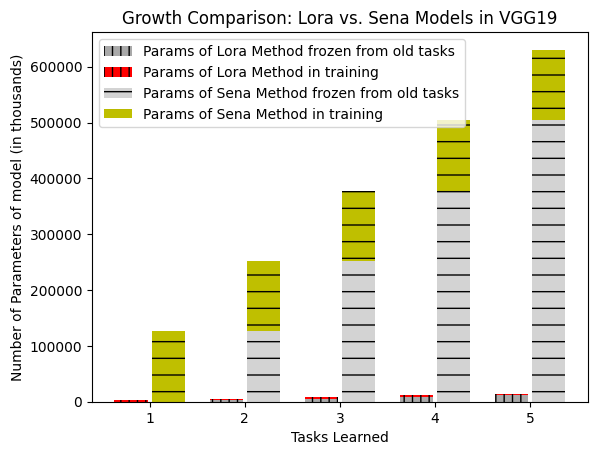

In [24]:
import matplotlib.pyplot as plt

"""
Lora 
Per task
 * in classifier: 1,940,680
 * in convolutional layers: 850,419
 ** Total: 2,791,099

Sena
 * in classifier: 120,365,256
 * in convolutional layers: 5,735,800  -- 13,110,400
 ** Total: 126,101,056
"""

# Example data
num_tasks = [i for i in range(1, 6)]  # Number of learned tasks
trainable_params_A = [2791]  # Number of trainable parameters for Model A
trainable_params_A.extend([2791 for _ in range(len(num_tasks) - 1)])
trainable_params_B = [126101]  # Number of trainable parameters for Model B
trainable_params_B.extend([126101 for _ in range(len(num_tasks) - 1)])

# Number of frozen parameters for Model A
frozen_params_A = [0]
for i in range(len(num_tasks) - 1):
    frozen_params_A.append(frozen_params_A[i] + trainable_params_A[i])

# Number of frozen parameters for Model B
frozen_params_B = [0]
for i in range(len(num_tasks) - 1):
    frozen_params_B.append(frozen_params_B[i] + trainable_params_B[i])

# Heights of the lower bars (frozen parameters)
bottom_A = frozen_params_A
bottom_B = frozen_params_B

# Heights of the upper bars (trainable parameters)
top_A = [param_a + param_t for param_a, param_t in zip(frozen_params_A, trainable_params_A)]
top_B = [param_b + param_t for param_b, param_t in zip(frozen_params_B, trainable_params_B)]

# Bar width
width = 0.35

# Creating the plot
fig, ax = plt.subplots()

# Adding the bars
ax.bar([(n - 0.02) for n in num_tasks], frozen_params_A, width, label='Params of Lora Method frozen from old tasks', hatch='||', color='darkgray')
ax.bar([(n - 0.02) for n in num_tasks], trainable_params_A, width, bottom=bottom_A, label='Params of Lora Method in training', hatch='||', color='r')

ax.bar([(n + width + 0.02) for n in num_tasks], frozen_params_B, width, label='Params of Sena Method frozen from old tasks', hatch='-', color='lightgray')
ax.bar([(n + width + 0.02) for n in num_tasks], trainable_params_B, width, bottom=bottom_B, label='Params of Sena Method in training', hatch='-', color='y')

# Adding labels and title
ax.set_xlabel('Tasks Learned')
ax.set_ylabel('Number of Parameters of model (in thousands)')
ax.set_title('Growth Comparison: Lora vs. Sena Models in VGG19')
ax.set_xticks([n + width / 2 for n in num_tasks])
ax.set_xticklabels(num_tasks)
ax.legend()

# Displaying the plot
plt.savefig('growth-comparison-vgg19-all.png', dpi=300, transparent=True)
plt.show()


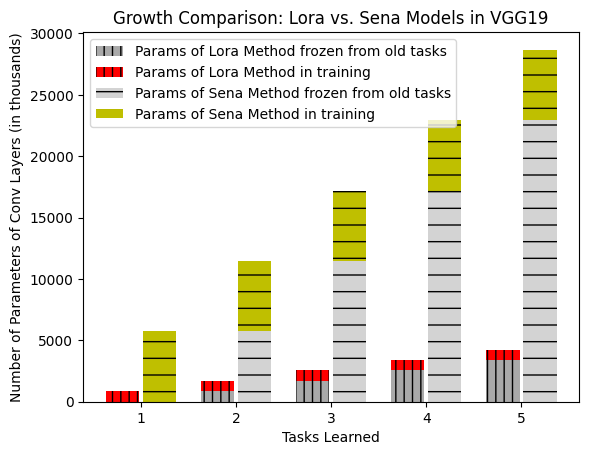

In [23]:
import matplotlib.pyplot as plt

"""
Lora 
Per task
 * in classifier: 1,940,680
 * in convolutional layers: 850,419
 ** Total: 2,791,099

Sena
 * in classifier: 120,365,256
 * in convolutional layers: 5,735,800
 ** Total: 126,101,056
"""

# Example data
num_tasks = [i for i in range(1, 6)]  # Number of learned tasks
trainable_params_A = [850]  # Number of trainable parameters for Model A
trainable_params_A.extend([850 for _ in range(len(num_tasks) - 1)])
trainable_params_B = [5735]  # Number of trainable parameters for Model B
trainable_params_B.extend([5735 for _ in range(len(num_tasks) - 1)])

# Number of frozen parameters for Model A
frozen_params_A = [0]
for i in range(len(num_tasks) - 1):
    frozen_params_A.append(frozen_params_A[i] + trainable_params_A[i])

# Number of frozen parameters for Model B
frozen_params_B = [0]
for i in range(len(num_tasks) - 1):
    frozen_params_B.append(frozen_params_B[i] + trainable_params_B[i])

# Heights of the lower bars (frozen parameters)
bottom_A = frozen_params_A
bottom_B = frozen_params_B

# Heights of the upper bars (trainable parameters)
top_A = [param_a + param_t for param_a, param_t in zip(frozen_params_A, trainable_params_A)]
top_B = [param_b + param_t for param_b, param_t in zip(frozen_params_B, trainable_params_B)]

# Bar width
width = 0.35

# Creating the plot
fig, ax = plt.subplots()

# Adding the bars
ax.bar([(n - 0.02) for n in num_tasks], frozen_params_A, width, label='Params of Lora Method frozen from old tasks', hatch='||', color='darkgray')
ax.bar([(n - 0.02) for n in num_tasks], trainable_params_A, width, bottom=bottom_A, label='Params of Lora Method in training', hatch='||', color='r')

ax.bar([(n + width + 0.02) for n in num_tasks], frozen_params_B, width, label='Params of Sena Method frozen from old tasks', hatch='-', color='lightgray')
ax.bar([(n + width + 0.02) for n in num_tasks], trainable_params_B, width, bottom=bottom_B, label='Params of Sena Method in training', hatch='-', color='y')

# Adding labels and title
ax.set_xlabel('Tasks Learned')
ax.set_ylabel('Number of Parameters of Conv Layers (in thousands)')
ax.set_title('Growth Comparison: Lora vs. Sena Models in VGG19')
ax.set_xticks([n + width / 2 for n in num_tasks])
ax.set_xticklabels(num_tasks)
ax.legend()

# Displaying the plot
plt.savefig('growth-comparison-vgg19-conv.png', dpi=300, transparent=True)
plt.show()
